Importing the relevant modules

In [377]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from sklearn.model_selection import train_test_split

pd.set_option('display.max_rows', 100)

Reading the csv files for the 3 apps we want to investigate (obtained from Sensor Tower)

In [378]:
data_over = pd.read_csv('Over.csv',encoding = 'utf-16')
data_postmates = pd.read_csv('Postmates.csv',encoding = 'utf-16')
data_spendingtracker = pd.read_csv('SpendingTracker.csv',encoding = 'utf-16')

Preprocessing a bit the data, dropping columns and rows we don't need and converting variables to numerical type

In [379]:
data_over = data_over.drop(['Sensor Tower Category Ranking Report', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 6'], axis = 1)
data_over.columns = ['Date', 'over_ipad_rank_photo_video','over_iphone_rank_photo_video']
data_over = data_over.drop(data_over.index[[0,1]])
data_over['over_ipad_rank_photo_video'] = data_over['over_ipad_rank_photo_video'].astype(int)
data_over['over_iphone_rank_photo_video'] = data_over['over_iphone_rank_photo_video'].astype(int)


data_postmates = data_postmates.drop(['Sensor Tower Category Ranking Report', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 6'], axis = 1)
data_postmates.columns = ['Date', 'postmates_iphone_rank_all_categories', 'postmates_ipad_rank_food','postmates_iphone_rank_food']
data_postmates = data_postmates.drop(data_postmates.index[[0,1]])
data_postmates['postmates_iphone_rank_all_categories'] = data_postmates['postmates_iphone_rank_all_categories'].astype(int)
#data_postmates['postmates_ipad_rank_food'] = data_postmates['postmates_ipad_rank_food'].astype(int) 
#data_postmates['postmates_iphone_rank_food'] = data_postmates['postmates_iphone_rank_food'].astype(int) 


data_spendingtracker = data_spendingtracker.drop(['Sensor Tower Category Ranking Report', 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 6'], axis = 1)
data_spendingtracker.columns = ['Date', 'spendingtracker_ipad_rank_finance','spendingtracker_iphone_rank_finance']
data_spendingtracker = data_spendingtracker.drop(data_spendingtracker.index[[0,1]])
data_spendingtracker['spendingtracker_ipad_rank_finance'] = data_spendingtracker['spendingtracker_ipad_rank_finance'].astype(int)
data_spendingtracker['spendingtracker_iphone_rank_finance'] = data_spendingtracker['spendingtracker_iphone_rank_finance'].astype(int)



Reading the downloads data of BS apps from csv file obtained from Sensor Tower, converting variables to numerical type and dropping columns we don't need

In [380]:
data_bs = pd.read_csv('BS_apps.csv', sep='\t', encoding = 'utf-16', skiprows=7)
data_bs['App ID'] = data_bs['App ID'].astype(int)
data_bs = data_bs.drop(['Unified ID', 'Unified Name', 'Unified Publisher','Unified Publisher Name', 'Parent Company Name', 'Publisher ID', 'Publisher Name', 'Country','Android Downloads', 'Android Revenue', 'iPad Revenue','iPhone Revenue',
       'Unified Total Downloads (Only for Unified CSV)', 'Unified Total Revenue (Only for Unified CSV)'], axis = 1)



Reading the rank data (among all categories, iPhone for now) of BS apps from csv file obtained from Sensor Tower, converting variables to numerical type and dropping columns we don't need

In [381]:
data_rank_bs = pd.read_csv('ranks_BS_all_cat.csv',sep='\t',encoding = 'utf-16')
data_rank_bs.columns = ['App ID', 'App Name', 'Country','Date', 'Rank all cat', 'Updated']
data_rank_bs = data_rank_bs.drop(data_rank_bs.index[[0,1]])
data_rank_bs = data_rank_bs.drop(['Country', 'Updated'], axis = 1)
data_rank_bs['App ID'] = data_rank_bs['App ID'].astype(int)

Merging the download and ranking data of BS apps

In [382]:
merged_data = pd.merge(data_bs, data_rank_bs, how='inner', on=['Date', 'App ID'])
merged_data = merged_data.dropna(axis=0)
merged_data = merged_data.drop(['App Name_y'], axis = 1)
merged_data['Rank all cat'] = merged_data['Rank all cat'].astype(float)

Plotting the data

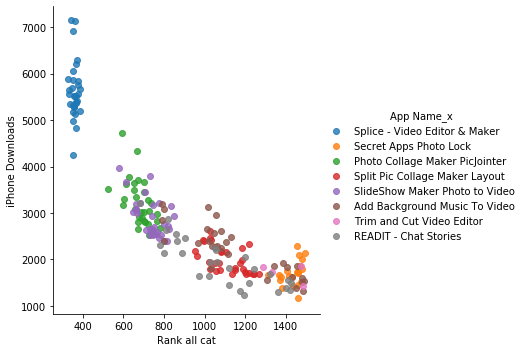

In [396]:
g = sns.lmplot(data=merged_data, y="iPhone Downloads", x="Rank all cat",hue ='App Name_x', fit_reg=False)
#g.set(ylim=(2000, 200))


The data seem to reflect and exponential decay
Fitting with an exponential function

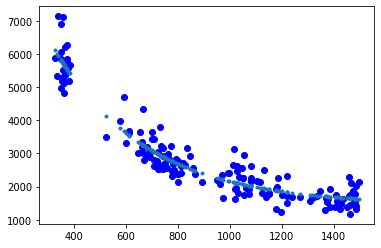

In [397]:
def func(x, a, b, c, d):    #exponential fitting function definition
    return a * np.exp(-b * (x - c)) + d

ydata = merged_data["iPhone Downloads"]
xdata = merged_data["Rank all cat"]
init_vals = [50, 0, 90, 63] #initial guesses for the fit

#test-train split
x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, test_size=0.2, random_state=42) 

#fitting the train test and plotting the results
coef, cov = curve_fit(func, x_train, y_train, p0=init_vals, bounds=([0, 0, 90, 0], [2000, 1, 2000, 2000]))
plt.plot(x_train, y_train, 'bo', label='data')
plt.plot(x_train, func(x_train, *coef),".")




In [398]:
#predicting the y values for the test set
y_pred = func(x_test, *coef)

#comparing the test set predicted and actual values
(y_pred/y_test).mean()

1.0161240939934526

In [399]:
#r_squared of the fit (at this stage I don't have the feeling to assess what can be a good r2 value for these data)
r_squared = 1 - ((y_test - y_pred)**2).sum()/((y_test-y_test.mean())**2).sum()
r_squared

0.9047856679335325

[3.81890616e+04 1.60363531e-03 1.30183234e+03 1.48692889e-08]


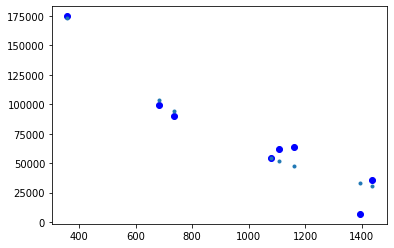

In [400]:
#Trying to repeat the analysis with the total number of downloads and the average rank for each app

grouped_data= merged_data.groupby('App Name_x').agg(downloads_avg=('iPhone Downloads', 'sum'),rank_avg=('Rank all cat', 'mean'))

ydata_grouped = grouped_data["downloads_avg"]
xdata_grouped = grouped_data["rank_avg"]
init_vals = [50, 0, 90, 63]

coef_grouped, cov_grouped = curve_fit(func, xdata_grouped, ydata_grouped, p0=init_vals, bounds=([0, 0, 90, 0], [50000, 1, 2000, 50000]))
plt.plot(xdata_grouped, ydata_grouped, 'bo', label='data')
plt.plot(xdata_grouped, func(xdata_grouped, *coef_grouped),".")
print(popt_grouped)


# Postmates

In [402]:
#predicting the total downloads for the Postmates app
x_data = data_postmates['postmates_iphone_rank_all_categories']
y_pred = func(x_data, *coef)
print('Predicted Postmates downloads: ', y_pred.sum())

Predicted Postmates downloads:  201448.13250437757


In [404]:
#analysis with the fit grom the grouped data
y_pred = func(x_data.mean(), *coef_grouped)
print('Predicted Postmates downloads (with grouped data): ', y_pred)

Predicted Postmates downloads (with grouped data):  190389.33665999456


# Over

I repeat the same analysis for the Over app

In [390]:
#we have only data for the Photo and Video category, so I load the corresponding ranking for BS apps
data_rank_bs_photo_video = pd.read_csv('ranks_BS_photo_video.csv',sep='\t',encoding = 'utf-16')
data_rank_bs_photo_video.columns = ['App ID', 'App Name', 'Country','Date', 'Rank Photo Video', 'Updated']
data_rank_bs_photo_video = data_rank_bs_photo_video.drop(data_rank_bs_photo_video.index[[0,1]])
data_rank_bs_photo_video = data_rank_bs_photo_video.drop(['Country', 'Updated'], axis = 1)
data_rank_bs_photo_video['App ID'] = data_rank_bs_photo_video['App ID'].astype(int)

In [391]:
data_rank_bs_photo_video

,App ID,App Name,Date,Rank Photo Video
2,409838725,Splice - Video Editor,2017-10-01,22
3,409838725,Splice - Video Editor,2017-10-02,22
4,409838725,Splice - Video Editor,2017-10-03,23
5,409838725,Splice - Video Editor,2017-10-04,25
6,409838725,Splice - Video Editor,2017-10-05,25
...,...,...,...,...
183,1158660999,Trim and Cut Video Editor,2017-10-27,113
184,1158660999,Trim and Cut Video Editor,2017-10-28,123
185,1158660999,Trim and Cut Video Editor,2017-10-29,122
186,1158660999,Trim and Cut Video Editor,2017-10-30,132


In [392]:
merged_data_photo_video = pd.merge(data_bs, data_rank_bs_photo_video, how='inner', on=['Date', 'App ID'])
merged_data_photo_video = merged_data_photo_video.dropna(axis=0)
merged_data_photo_video = merged_data_photo_video.drop(['App Name_y'], axis = 1)
merged_data_photo_video['Rank Photo Video'] = merged_data_photo_video['Rank Photo Video'].astype(float)

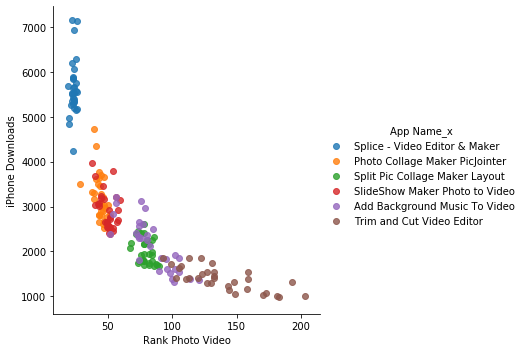

In [393]:
g = sns.lmplot(data=merged_data_photo_video, y="iPhone Downloads", x="Rank Photo Video",hue ='App Name_x', fit_reg=False)
#g.set(ylim=(2000, 200))

0.87727883448688

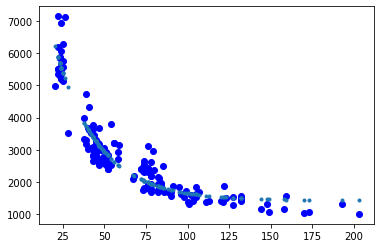

In [394]:
#The following 4 lines are here to restrict the analysis only to data in a certain range, I comment them out for now
#ydata = merged_data_photo_video["iPhone Downloads"].where(merged_data_photo_video["Rank Photo Video"]>10)
#xdata = merged_data_photo_video["Rank Photo Video"].where(merged_data_photo_video["Rank Photo Video"]>10)
#xdata = xdata.dropna()
#ydata = ydata.dropna()

init_vals = [50, 0, 90, 63] #initial guesses for the fit

#test-train split
x_train, x_test, y_train, y_test = train_test_split(xdata, ydata, test_size=0.2, random_state=42) 

#fitting the train test and plotting the results
coef, cov = curve_fit(func, x_train, y_train, p0=init_vals, bounds=([0, 0, 90, 0], [2000, 1, 2000, 2000]))
plt.plot(x_train, y_train, 'bo', label='data')
plt.plot(x_train, func(x_train, *coef),".")


#predicting the y values for the test set
y_pred = func(x_test, *coef)

#comparing the test set predicted and actual values
#(y_pred/y_test).mean()

#r_squared of the fit (at this stage I don't have the feeling to assess what can be a good r2 value for these data)
r_squared = 1 - ((y_test - y_pred)**2).sum()/((y_test-y_test.mean())**2).sum()
r_squared

In [405]:
#predicting the total downloads for the Over app
x_data = data_over['over_iphone_rank_photo_video']
y_pred = func(x_data, *coef)
print('Predicted Over downloads: ', y_pred.sum())


Predicted Over downloads:  45196.981091874746


# Spending Tracker

Sensor Tower has rank data on Spending Tower only in the Finance category; none of the BS apps fall into this group. Using other rank data on BS apps doesn't seem to reliable. Is there any other way to predict its downloads?